In [2]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### DS Patient Hours Recomendation Models

#### Plan is to train boosted tree model with both sfere and claims features
- Use last 30d as test set
- also train two versions of quantile model on best features
    1. with current hrs
    2. without current hrs

In [36]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_rec_hrs_modelling_w_claims_20221205.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df.head()

14539 samples


,sfere_id,patient_id,payer_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,submitted_last_30d,glaucoma_ddos_ft,cataract_ddos_ft,behavioral_health_ddos_ft,osteoporosis_ddos_ft,hiv_ddos_ft,transplants_ddos_ft,obesity_ddos_ft,cancer_ddos_ft,hip_pelvic_fracture_ddos_ft,sclerosis_ddos_ft,rheumatoid_arthritis_ddos_ft,ckd_ddos_ft,hyperlipidemia_ddos_ft,diabetes_ddos_ft,hypothyroidism_ddos_ft,pressure_ulcer_ddos_ft,weight_loss_ddos_ft,heart_ddos_ft,peptic_ulcer_ddos_ft,anemia_ddos_ft,substance_abuse_ddos_ft,liver_ddos_ft,disabled_ddos_ft,fall_ddos_ft,stroke_ddos_ft,paralysis_ddos_ft,hypertension_ddos_ft,peripheral_vascular_ddos_ft,coagulation_ddos_ft,fluid_ddos_ft,benign_prostatic_hyperplasia_ddos_ft,tbi_ddos_ft,neurocognitive_ddos_ft,pulmonary_ddos_ft,glaucoma_tc_ft,cataract_tc_ft,behavioral_health_tc_ft,osteoporosis_tc_ft,hiv_tc_ft,transplants_tc_ft,obesity_tc_ft,cancer_tc_ft,hip_pelvic_fracture_tc_ft,sclerosis_tc_ft,rheumatoid_arthritis_tc_ft,ckd_tc_ft,hyperlipidemia_tc_ft,diabetes_tc_ft,hypothyroidism_tc_ft,pressure_ulcer_tc_ft,weight_loss_tc_ft,heart_tc_ft,peptic_ulcer_tc_ft,anemia_tc_ft,substance_abuse_tc_ft,liver_tc_ft,disabled_tc_ft,fall_tc_ft,stroke_tc_ft,paralysis_tc_ft,hypertension_tc_ft,peripheral_vascular_tc_ft,coagulation_tc_ft,fluid_tc_ft,benign_prostatic_hyperplasia_tc_ft,tbi_tc_ft,neurocognitive_tc_ft,pulmonary_tc_ft
0,33,1,2,84,2,2,2,2,2,2,2.0,2,NaN,1,NaN,0.0,2,1,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,30.0,25.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,0.0,0.0,0.0,15.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,10.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,62.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,1154.87,3422.46,0.0,0.00,0.00,6347.46,0.0,163.51,0.0,0.0,0.0,84.76,129.71,0.00,939.89,3218.26,0.0,0.00,0.0,0.0,0.00,0.00
1,6254,1,2,84,2,2,2,2,2,0,2.0,2,NaN,0,NaN,NaN,1,0,2,0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,15.0,15.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,14.0,0.0,2.0,1.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,49.64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,250.88,135.16,1252.28,0.0,139.80,126.89,3083.94,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,499.63,1221.50,0.0,68.35,0.0,0.0,0.00,0.00
2,131,2,2,75,3,3,3,2,3,0,2.0,3,NaN,1,NaN,2.0,0,0,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1.0,1.0,48.0,40.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,14.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.61,0.00,44.29,1052.48,0.0,34.44,0.00,0.00,0.0,409.55,0.0,0.0,0.0,0.00,0.00,0.00,1227.56,0.00,0.0,0.00,0.0,0.0,746.83,55.14
3,9489,2,2,75,3,3,3,3,3,1,3.0,3,NaN,1,2.0,2.0,0,1,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,48.0,48.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,9.0,0.0,2.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2261.85,8.91,268.20,0.0,68.34,2095.43,68.34,0.0,0.00,0.0,0.0,0.0,0.00,392.44,0.00,1275.47,0.00,0.0,0.00,0.0,0.0,2560.14,105.42
4,6360,4,2,52,2,2,2,2,2,0,2.0,2,NaN,1,0.0,0.0,0,0,2,2,2.0,2.0,2.0,2.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0,35.0,35.

### Features

In [120]:
potential_features = [f for f in df.columns if f.endswith('_ft')]
potential_features 

['payer_id_ft',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'reporting_current_hrs_ft',
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplants_ddos_ft',
 'ob

### Modeling

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [225]:
categorical_features = [
 'payer_id_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
]

cont_features = [
 # 'reporting_current_hrs_ft',
 'age_ft',
    
 'glaucoma_ddos_ft',
 'cataract_ddos_ft',
 'behavioral_health_ddos_ft',
 'osteoporosis_ddos_ft',
 'hiv_ddos_ft',
 'transplants_ddos_ft',
 'obesity_ddos_ft',
 'cancer_ddos_ft',
 'hip_pelvic_fracture_ddos_ft',
 'sclerosis_ddos_ft',
 'rheumatoid_arthritis_ddos_ft',
 'ckd_ddos_ft',
 'hyperlipidemia_ddos_ft',
 'diabetes_ddos_ft',
 'hypothyroidism_ddos_ft',
 'pressure_ulcer_ddos_ft',
 'weight_loss_ddos_ft',
 'heart_ddos_ft',
 'peptic_ulcer_ddos_ft',
 'anemia_ddos_ft',
 'substance_abuse_ddos_ft',
 'liver_ddos_ft',
 'disabled_ddos_ft',
 'fall_ddos_ft',
 'stroke_ddos_ft',
 'paralysis_ddos_ft',
 'hypertension_ddos_ft',
 'peripheral_vascular_ddos_ft',
 'coagulation_ddos_ft',
 'fluid_ddos_ft',
 'benign_prostatic_hyperplasia_ddos_ft',
 'tbi_ddos_ft',
 'neurocognitive_ddos_ft',
 'pulmonary_ddos_ft',
    
 #     'glaucoma_tc_ft',
 # 'cataract_tc_ft',
 # 'behavioral_health_tc_ft',
 # 'osteoporosis_tc_ft',
 # 'hiv_tc_ft',
 # 'transplants_tc_ft',
 # 'obesity_tc_ft',
 # 'cancer_tc_ft',
 # 'hip_pelvic_fracture_tc_ft',
 # 'sclerosis_tc_ft',
 # 'rheumatoid_arthritis_tc_ft',
 # 'ckd_tc_ft',
 # 'hyperlipidemia_tc_ft',
 # 'diabetes_tc_ft',
 # 'hypothyroidism_tc_ft',
 # 'pressure_ulcer_tc_ft',
 # 'weight_loss_tc_ft',
 # 'heart_tc_ft',
 # 'peptic_ulcer_tc_ft',
 # 'anemia_tc_ft',
 # 'substance_abuse_tc_ft',
 # 'liver_tc_ft',
 # 'disabled_tc_ft',
 # 'fall_tc_ft',
 # 'stroke_tc_ft',
 # 'paralysis_tc_ft',
 # 'hypertension_tc_ft',
 # 'peripheral_vascular_tc_ft',
 # 'coagulation_tc_ft',
 # 'fluid_tc_ft',
 # 'benign_prostatic_hyperplasia_tc_ft',
 # 'tbi_tc_ft',
 # 'neurocognitive_tc_ft',
 # 'pulmonary_tc_ft'
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

In [226]:
df[categorical_features].head()

,payer_id_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft
0,2,2,2,2,2,2,2,2.0,2,NaN,1,NaN,0.0,2,1,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0
1,2,2,2,2,2,2,0,2.0,2,NaN,0,NaN,NaN,1,0,2,0,0.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0
2,2,3,3,3,2,3,0,2.0,3,NaN,1,NaN,2.0,0,0,2,2,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,1.0,1.0
3,2,3,3,3,3,3,1,3.0,3,NaN,1,2.0,2.0,0,1,1,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0
4,2,2,2,2,2,2,0,2.0,2,NaN,1,0.0,0.0,0,0,2,2,2.0,2.0,2.0,2.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,0.0


In [227]:
# make sure data always exists
missing_cat = df[categorical_features].count() / df.shape[0]

In [228]:
# features present in < 70% samples
low_freq_feats = [x for x in missing_cat.items() if x[1] <= .7]
low_freq_feats 

[('turn_change_position_ft', 0.07070637595432973),
 ('incontinence_type_ft', 0.5253456221198156),
 ('incontinence_frequency_ft', 0.6509388541165142),
 ('cleaning_ft', 0.06369076277598185),
 ('laundry_ft', 0.16115276153793245),
 ('change_bed_ft', 0.03638489579751014),
 ('clean_kitchen_ft', 0.03638489579751014),
 ('clean_home_ft', 0.03638489579751014),
 ('medical_appointments_ft', 0.07070637595432973),
 ('work_school_socialize_ft', 0.03638489579751014)]

In [229]:
# make sure data always exists
missing_cont = df[cont_features].count() / df.shape[0]
missing_cont

age_ft                                  1.000000
glaucoma_ddos_ft                        0.880322
cataract_ddos_ft                        0.880322
behavioral_health_ddos_ft               0.880322
osteoporosis_ddos_ft                    0.880322
hiv_ddos_ft                             0.880322
transplants_ddos_ft                     0.880322
obesity_ddos_ft                         0.880322
cancer_ddos_ft                          0.880322
hip_pelvic_fracture_ddos_ft             0.880322
sclerosis_ddos_ft                       0.880322
rheumatoid_arthritis_ddos_ft            0.880322
ckd_ddos_ft                             0.880322
hyperlipidemia_ddos_ft                  0.880322
diabetes_ddos_ft                        0.880322
hypothyroidism_ddos_ft                  0.880322
pressure_ulcer_ddos_ft                  0.880322
weight_loss_ddos_ft                     0.880322
heart_ddos_ft                           0.880322
peptic_ulcer_ddos_ft                    0.880322
anemia_ddos_ft      

In [230]:
len(features)

72

In [231]:
# Likely want to drop low frequency features in categorical vars
lf_feats = [lff[0] for lff in low_freq_feats]
features = [f for f in features if f not in lf_feats]

In [230]:
len(features)

72

In [233]:
len(categorical_features)

37

In [234]:
# need to drop the low_freq categorical feature indexes
categorical_feature_indexes = categorical_feature_indexes[:-len(low_freq_feats)]

In [235]:
len(categorical_feature_indexes)

27

### Train Validation Test Split

In [57]:
# test set: all sferes submitted in last 30d plus any other sferes for thos patients
test_df = df.loc[df.submitted_last_30d]
test_df_patient_ids = test_df.patient_id.unique()
test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
print(f'{test_df.shape[0]} test samples, for {test_df_patient_ids.shape[0]} unique patients')

1808 test samples, for 1523 patients


In [72]:
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]
training_df_patient_ids = training_df.patient_id.unique()
print(f'{training_df.shape[0]} training samples, for {training_df_patient_ids.shape[0]} unique patients')

12731 training samples, for 11116 unique patients


In [77]:
val_pct = 0.15
val_df_patient_ids = random.sample(list(training_df_patient_ids), int(training_df.shape[0]*val_pct))
val_df = training_df.loc[training_df.patient_id.isin(val_df_patient_ids)]
val_df.shape[0]
print(f'{val_df.shape[0]} val samples, for {len(val_df_patient_ids)} unique patients')

2189 val samples, for 1909 unique patients


In [78]:
train_no_val_df = training_df.loc[~training_df.patient_id.isin(val_df_patient_ids)]
print(f'{train_no_val_df.shape[0]} train samples, for {train_no_val_df.patient_id.unique().shape[0]} unique patients')

10542 train samples, for 9207 unique patients


### All assessor model

In [236]:
x_train = train_no_val_df[features]
y_train = train_no_val_df[target]

x_val = val_df[features]
y_val = val_df[target]

In [237]:
aa_est = HistGradientBoostingRegressor(categorical_features=categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

In [238]:
aa_preds = aa_est.predict(x_val)

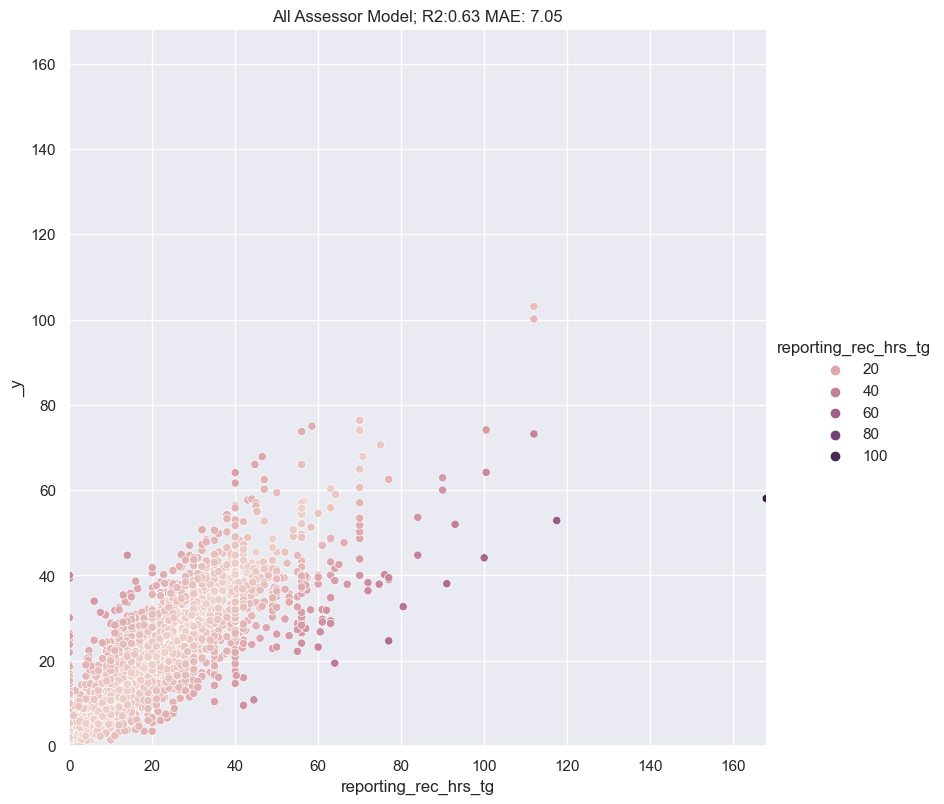

In [239]:
# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds, height=8, hue=np.abs(y_val - aa_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model; R2:{aa_est.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds)):.02f}');

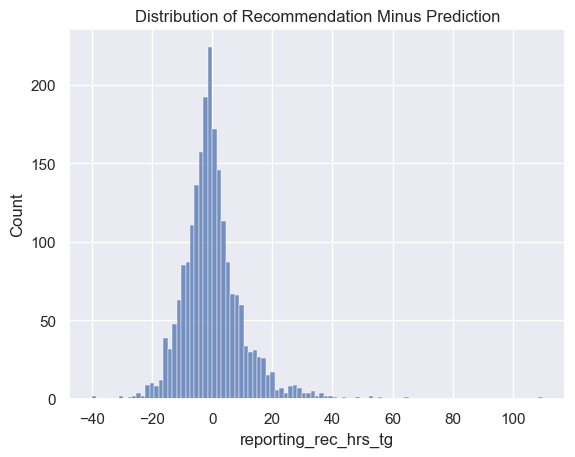

In [240]:
ax = sns.histplot(x=y_val - aa_preds)
ax.set(title=f'Distribution of Recommendation Minus Prediction');

In [241]:
from sklearn.inspection import permutation_importance

In [242]:
print('All assessor model features')
r = permutation_importance(aa_est, x_val, y_val,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

All assessor model features


In [243]:
best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")
best_features

payer_id_ft 0.515  +/- 0.023
toileting_ft 0.068  +/- 0.006
meal_prep_ft 0.029  +/- 0.004
dressing_ft 0.021  +/- 0.003
housework_ft 0.019  +/- 0.004
age_ft   0.017  +/- 0.004
grooming_ft 0.017  +/- 0.003
transfer_bed_to_chair_ft 0.013  +/- 0.003
eating_ft 0.011  +/- 0.003
bathing_ft 0.010  +/- 0.002
transfer_chair_to_standing_ft 0.008  +/- 0.002
transportation_ft 0.008  +/- 0.001
paralysis_ddos_ft 0.006  +/- 0.002
comprehension_ft 0.003  +/- 0.002
neurocognitive_ddos_ft 0.003  +/- 0.001
has_dementia_ft 0.003  +/- 0.001
alert_oriented_day_time_ft 0.003  +/- 0.001
pressure_ulcer_ddos_ft 0.002  +/- 0.001
alert_oriented_self_ft 0.002  +/- 0.000


['payer_id_ft',
 'toileting_ft',
 'meal_prep_ft',
 'dressing_ft',
 'housework_ft',
 'age_ft',
 'grooming_ft',
 'transfer_bed_to_chair_ft',
 'eating_ft',
 'bathing_ft',
 'transfer_chair_to_standing_ft',
 'transportation_ft',
 'paralysis_ddos_ft',
 'comprehension_ft',
 'neurocognitive_ddos_ft',
 'has_dementia_ft',
 'alert_oriented_day_time_ft',
 'pressure_ulcer_ddos_ft',
 'alert_oriented_self_ft']

### Try retraining on only the top features

In [246]:
b_categorical_features = [c for c in categorical_features if c in best_features]
b_cat_feat_indexes = [i for i in range(len(b_categorical_features))]
b_categorical_features, b_cat_feat_indexes

(['payer_id_ft',
  'transfer_bed_to_chair_ft',
  'transfer_chair_to_standing_ft',
  'dressing_ft',
  'bathing_ft',
  'eating_ft',
  'grooming_ft',
  'toileting_ft',
  'meal_prep_ft',
  'housework_ft',
  'transportation_ft',
  'comprehension_ft',
  'alert_oriented_self_ft',
  'alert_oriented_day_time_ft',
  'has_dementia_ft'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [245]:
b_cont_features = [c for c in cont_features if c in best_features]
b_cont_features

['age_ft',
 'pressure_ulcer_ddos_ft',
 'paralysis_ddos_ft',
 'neurocognitive_ddos_ft']

In [248]:
b_features = b_categorical_features + b_cont_features

In [249]:
x_train = train_no_val_df[b_features]
y_train = train_no_val_df[target]

x_val = val_df[b_features]
y_val = val_df[target]

In [250]:
aa_est = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                       max_iter=1000).fit(x_train, y_train)

In [251]:
aa_preds = aa_est.predict(x_val)

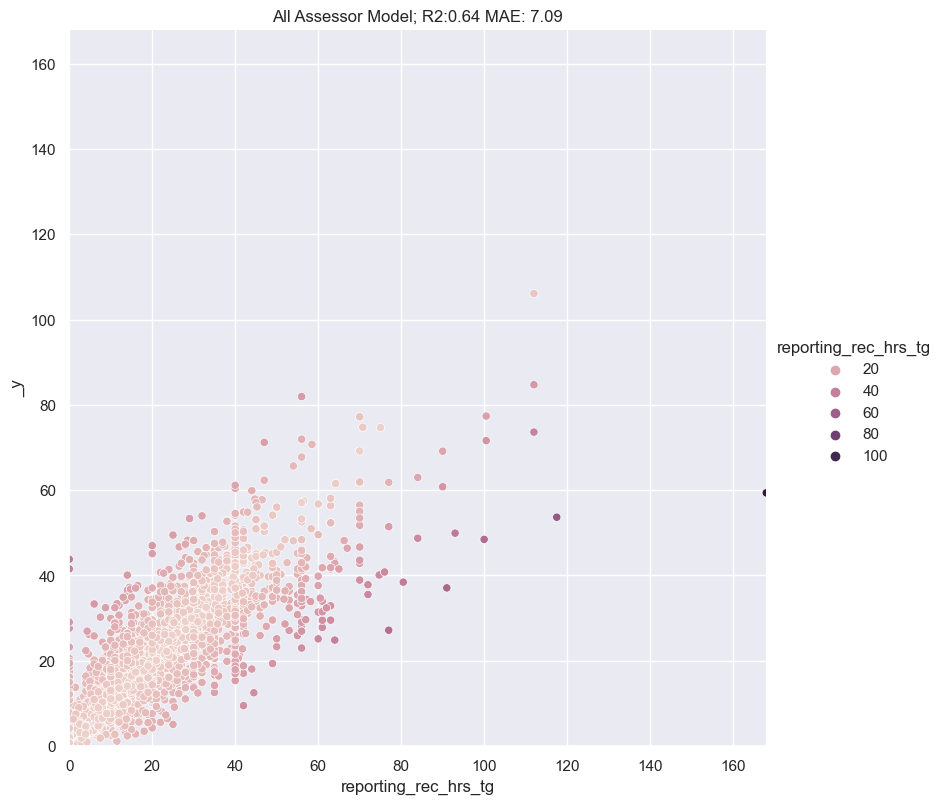

In [252]:
# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds, height=8, hue=np.abs(y_val - aa_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model on best features only; R2:{aa_est.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds)):.02f}');

In [337]:
# results pulled from multithreaded script
results_df = pd.read_csv('combo_model_tuning_results_20221205.csv')
results_df.sort_values('score', ascending=False).head()

,score,mae,l2,lr,mi,mln,md,msl
2499,0.615788,7.298023,0.01,0.20,1000,10.0,5.0,50
2498,0.614613,7.346831,0.10,0.05,1000,10.0,NaN,40
2497,0.614603,7.347810,0.10,0.20,1000,10.0,10.0,50
2496,0.614348,7.327815,0.01,0.10,1000,10.0,20.0,40
2495,0.614004,7.323881,0.00,0.05,1000,20.0,NaN,40


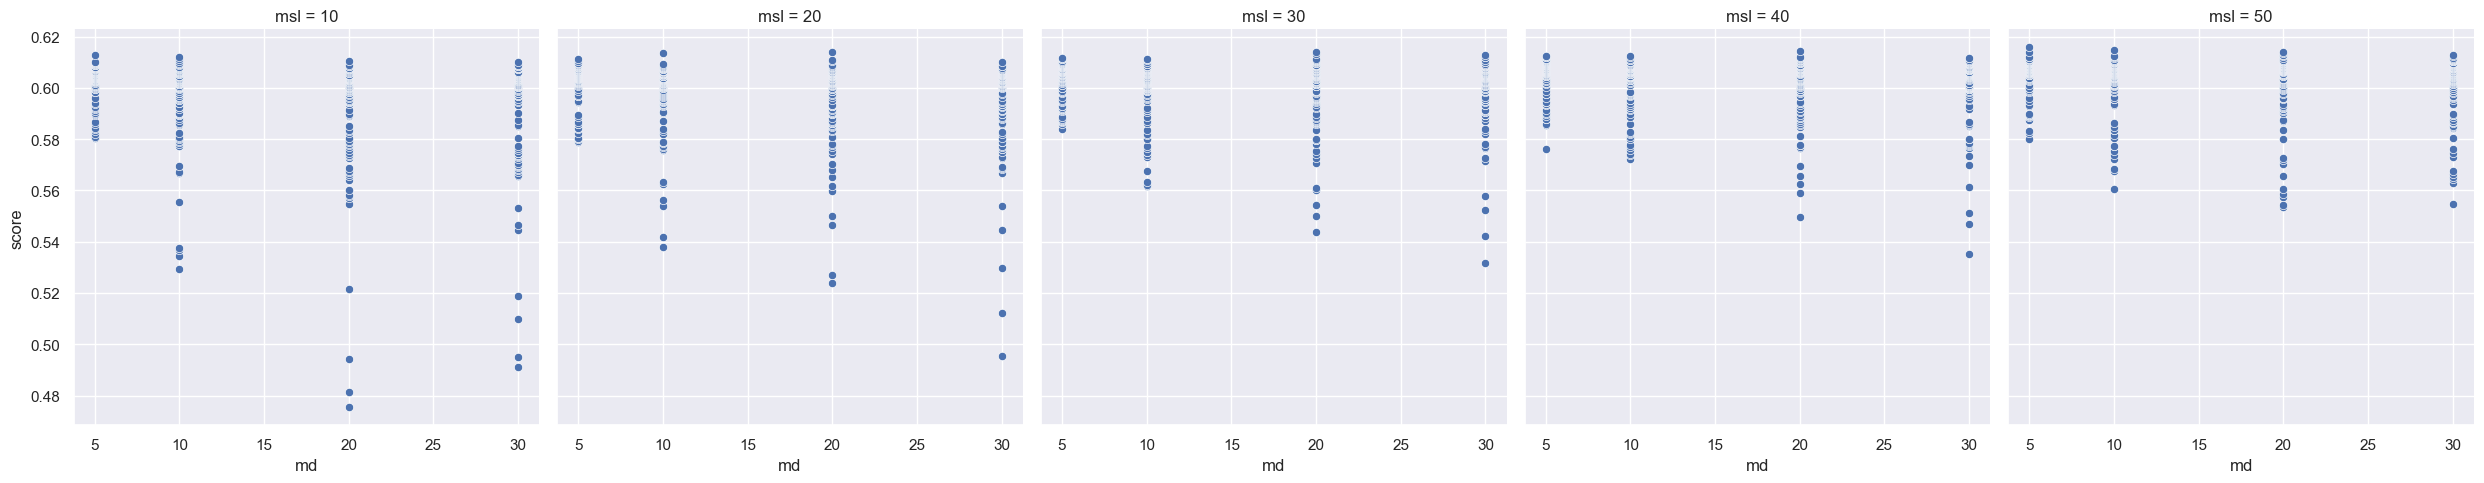

In [362]:
# sns.relplot(data=results_df, y='score', x='msl')
sns.relplot(data=results_df, y='score', x='md', col='msl')

#### Take aways for hyperparams:
    - smaller LR 
    - slight l2 .01
    - smaller < 10 mln
    - smaller <= 5 md
    - bigger msl 30 - 50

### Train quantile model 

In [274]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                            loss="quantile",
                                            quantile=LOWER_ALPHA
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(categorical_features=b_cat_feat_indexes,
                                            loss="quantile",
                                            quantile=UPPER_ALPHA
                                           ).fit(x_train, y_train)

In [275]:
l_preds = lower_model.predict(x_val)
h_preds = upper_model.predict(x_val)

In [323]:
q_results = []
for row in zip(y_val, l_preds, h_preds, aa_preds):
    q_results.append(row)
q_results_df = pd.DataFrame(q_results, columns=['actual', 'low', 'high', 'best']) 

In [332]:
q_results_df = q_results_df.assign(
    mae=np.abs(q_results_df.best - q_results_df.actual), 
    in_range=(q_results_df.actual >= q_results_df.low) & (q_results_df.actual <= q_results_df.high),
    out_of_range=np.where(q_results_df.actual > q_results_df.high, 'actual_higher', np.where(q_results_df.actual < q_results_df.low, 'actual_lower', 'in_range'))
)
q_results_df.head()

,actual,low,high,best,mae,in_range,out_of_range
0,30.0,21.504844,60.963644,39.950006,9.950006,True,in_range
1,30.0,15.533000,59.298784,31.804154,1.804154,True,in_range
2,56.0,13.976332,55.598318,32.331490,23.668510,False,actual_higher
3,55.0,2.760284,42.967126,24.906334,30.093666,False,actual_higher
4,61.0,17.850209,63.022410,41.573272,19.426728,True,in_range


In [333]:
q_melt = pd.melt(q_results_df, id_vars=['actual', 'mae', 'in_range', 'out_of_range'], value_vars=['low', 'high', 'best'])
q_melt.head()

,actual,mae,in_range,out_of_range,variable,value
0,30.0,9.950006,True,in_range,low,21.504844
1,30.0,1.804154,True,in_range,low,15.533000
2,56.0,23.668510,False,actual_higher,low,13.976332
3,55.0,30.093666,False,actual_higher,low,2.760284
4,61.0,19.426728,True,in_range,low,17.850209


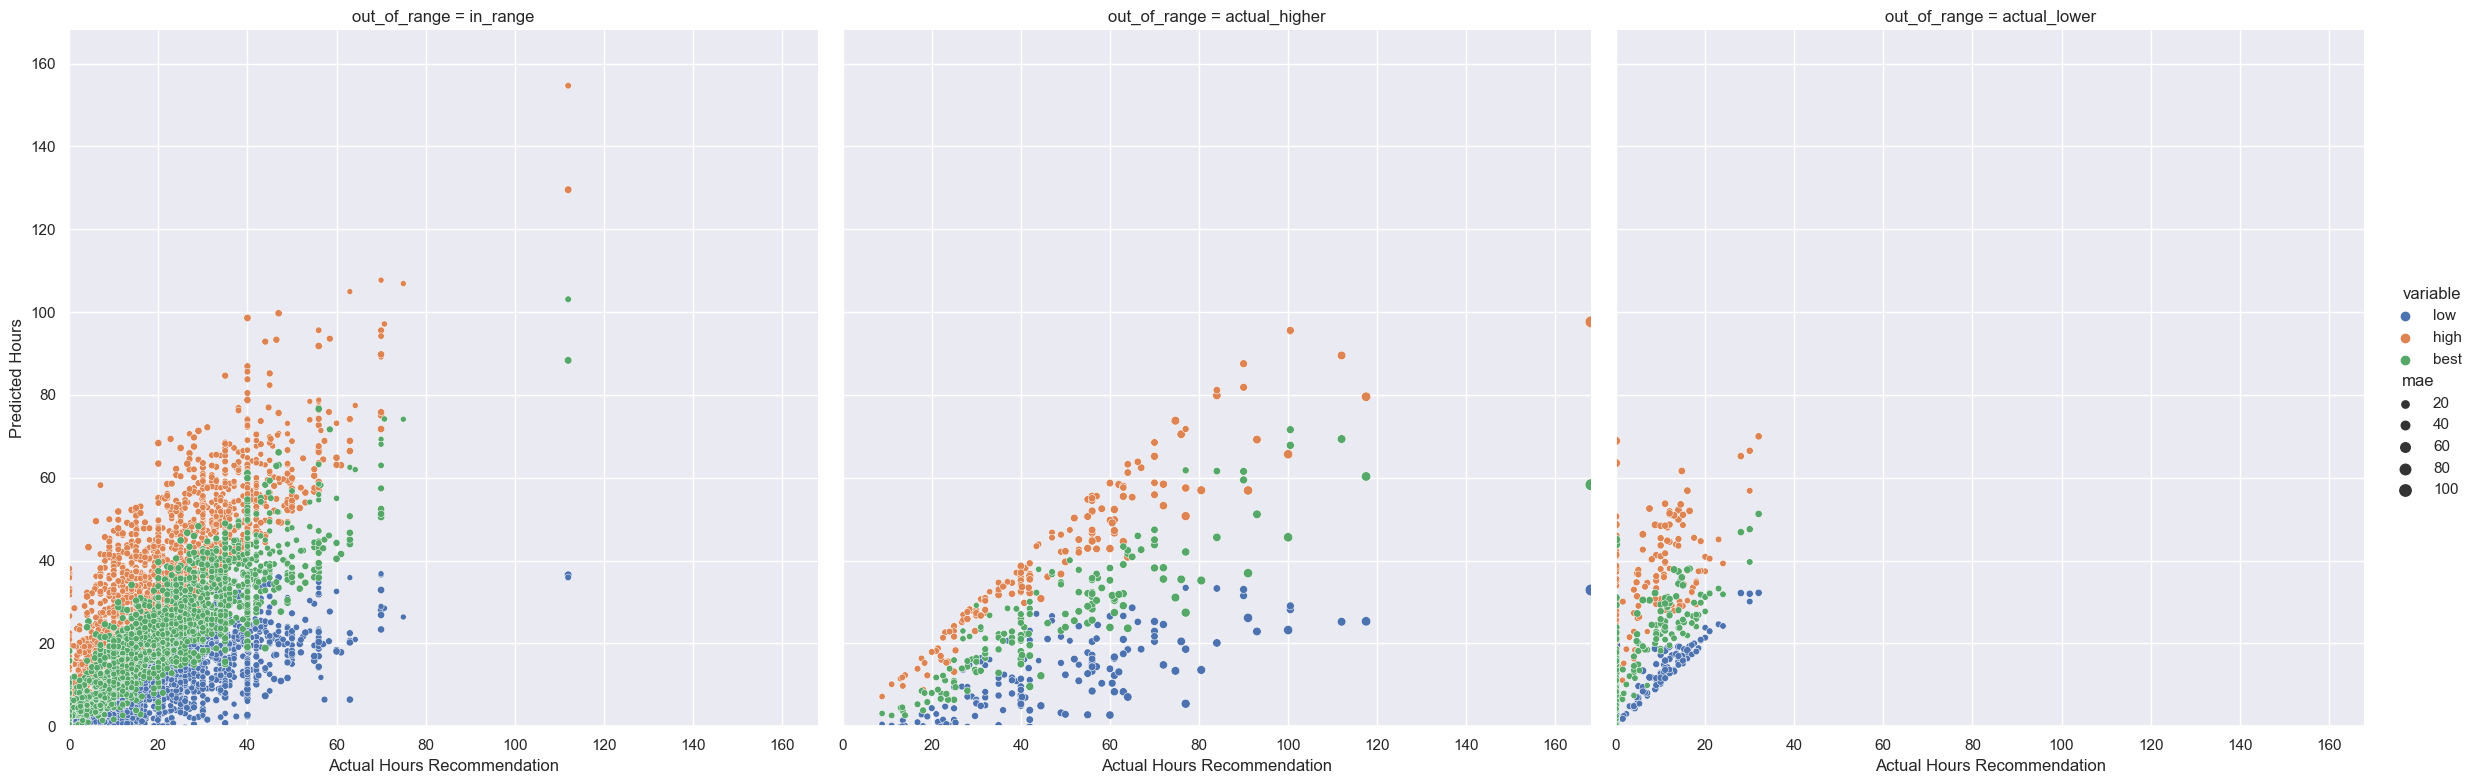

In [334]:
ax = sns.relplot(data=q_melt, x='actual', col='out_of_range', size='mae', y='value', hue='variable', height=8)
# ax = sns.relplot(data=q_melt, x='actual',  col='in_range', size='mae', y='value', hue='variable', height=8)
ax.set(
    # title=f'quantile',
    ylim=(0, 168),
    xlim=(0, 168),
    xlabel='Actual Hours Recommendation',
    ylabel='Predicted Hours');

### Train 5 models on best features and tuned hyperparams
    - Combo Model
    - Quantile Low no current hrs
    - Quantile High no current hrs
    - Quantile Low w/current hrs
    - Quantile High w/current hrs
 
Can use both train and val data. Predict on the test set for review

In [366]:
b_features, b_cat_feat_indexes

(['payer_id_ft',
  'transfer_bed_to_chair_ft',
  'transfer_chair_to_standing_ft',
  'dressing_ft',
  'bathing_ft',
  'eating_ft',
  'grooming_ft',
  'toileting_ft',
  'meal_prep_ft',
  'housework_ft',
  'transportation_ft',
  'comprehension_ft',
  'alert_oriented_self_ft',
  'alert_oriented_day_time_ft',
  'has_dementia_ft',
  'age_ft',
  'pressure_ulcer_ddos_ft',
  'paralysis_ddos_ft',
  'neurocognitive_ddos_ft'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [368]:
x_train = training_df[b_features]
y_train = training_df[target]

x_test = test_df[b_features]
y_test = test_df[target]

In [381]:
hyper_params = {
    'categorical_features': b_cat_feat_indexes,
    'l2_regularization': 0.01,
    'min_samples_leaf': 30,
    'max_depth': 5,
    'max_leaf_nodes': 10,
    'max_iter': 5000
}

In [381]:
combo_est = HistGradientBoostingRegressor(**hyper_params).fit(x_train, y_train)

In [382]:
combo_preds = combo_est.predict(x_test)

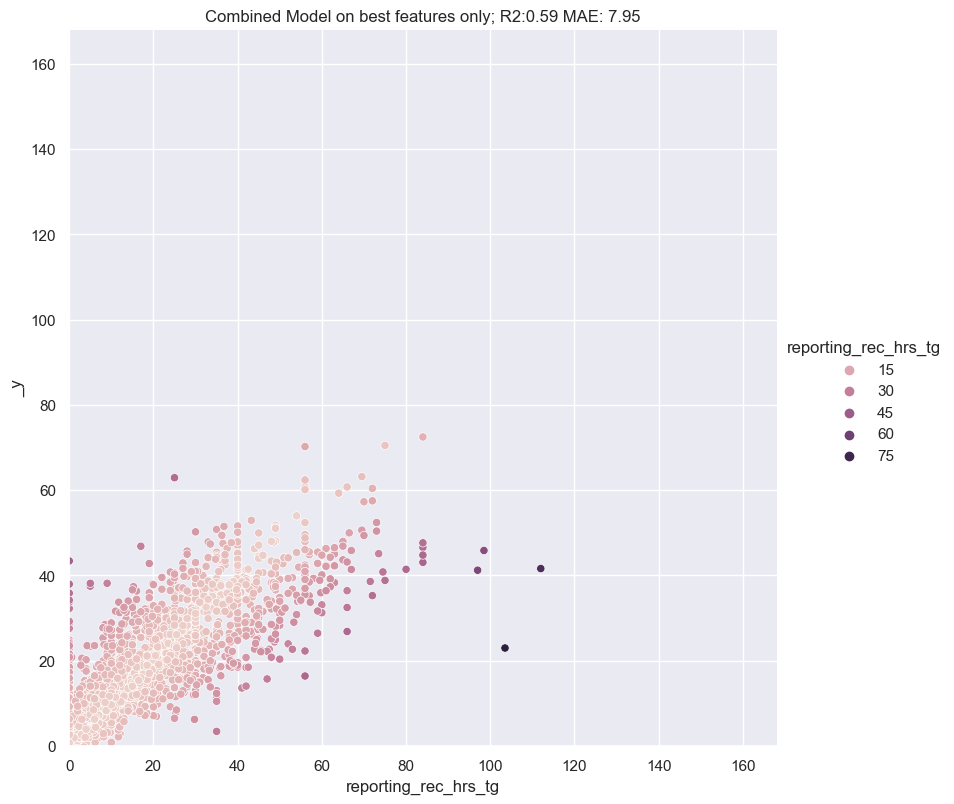

In [383]:
# preds vs rec
ax = sns.relplot(x=y_test, y=combo_preds, height=8, hue=np.abs(y_test - combo_preds))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Combined Model on best features only; R2:{combo_est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - combo_preds)):.02f}');

In [385]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=LOWER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=UPPER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

In [386]:
l_preds = lower_model.predict(x_test)
h_preds = upper_model.predict(x_test)

In [387]:
# add in current hrs
x_train = training_df[b_features + ['reporting_current_hrs_ft']]
y_train = training_df[target]

x_test = test_df[b_features + ['reporting_current_hrs_ft']]
y_test = test_df[target]

In [388]:
# Set lower and upper quantile
LOWER_ALPHA = 0.05
UPPER_ALPHA = 0.95

lower_model_ch = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=LOWER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

upper_model_ch = HistGradientBoostingRegressor(loss="quantile",
                                            quantile=UPPER_ALPHA,
                                            **hyper_params
                                           ).fit(x_train, y_train)

In [389]:
l_preds_ch = lower_model_ch.predict(x_test)
h_preds_ch = upper_model_ch.predict(x_test)

In [396]:
out_cols = ['sfere_id', 'patient_id', 'reporting_current_hrs_ft', target]
output_df = test_df[out_cols + b_features].assign(predicted_hrs=combo_preds,
                                                  error=np.abs(combo_preds - y_test),
                                                  lower_bound_preds=l_preds,
                                                  upper_bound_preds=h_preds,
                                                  lower_bound_preds_w_cur_hrs=l_preds_ch,
                                                  upper_bound_preds_w_cur_hrs=h_preds_ch)

In [397]:
err_std_by_payer = output_df.groupby('payer_id_ft').error.std().to_dict()
output_df = output_df.assign(payer_error_std=output_df.apply(lambda x: x.error / err_std_by_payer[x.payer_id_ft], axis=1),
                             in_range=(output_df.reporting_rec_hrs_tg >= output_df.lower_bound_preds) & (output_df.reporting_rec_hrs_tg <= output_df.upper_bound_preds),
                             in_range_w_cur_hrs=(output_df.reporting_rec_hrs_tg >= output_df.lower_bound_preds_w_cur_hrs) & (output_df.reporting_rec_hrs_tg <= output_df.upper_bound_preds_w_cur_hrs),
                            )

In [398]:
output_df.head()

,sfere_id,patient_id,reporting_current_hrs_ft,reporting_rec_hrs_tg,payer_id_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_self_ft,alert_oriented_day_time_ft,has_dementia_ft,age_ft,pressure_ulcer_ddos_ft,paralysis_ddos_ft,neurocognitive_ddos_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs
84,32631,116,24.0,20.0,2,2,2,2,0,0,0.0,0,2,2.0,2.0,1.0,1.0,0.0,NaN,75,0.0,0.0,20.0,29.868460,9.868460,0.0,52.889955,0.0,24.013889,1.158978,True,True
88,33549,124,40.0,32.0,2,0,0,2,2,0,2.0,2,2,2.0,2.0,0.0,1.0,1.0,0.0,70,0.0,0.0,0.0,31.462362,0.537638,0.0,50.372351,0.0,40.021621,0.063142,True,True
106,32544,142,40.0,40.0,2,2,2,2,2,1,2.0,2,2,2.0,2.0,0.0,1.0,1.0,0.0,88,1.0,4.0,0.0,35.406903,4.593097,0.0,58.370737,0.0,40.048387,0.539425,True,True
115,5394,154,45.0,45.0,2,3,3,3,3,0,2.0,3,2,2.0,1.0,NaN,1.0,1.0,0.0,85,3.0,2.0,0.0,44.469733,0.530267,0.0,63.223609,0.0,45.131703,0.062276,True,True
116,113,157,49.0,42.0,2,0,2,2,2,0,2.0,0,1,1.0,2.0,NaN,1.0,1.0,0.0,41,0.0,0.0,0.0,26.354962,15.645038,0.0,43.676160,0.0,48.692610,1.837394,True,True


In [412]:
cols = [
 'sfere_id',
 'patient_id',
 'payer_id_ft',
 'reporting_rec_hrs_tg',
 'reporting_current_hrs_ft',
 'predicted_hrs',
 'error',
 'lower_bound_preds',
 'upper_bound_preds',
 'lower_bound_preds_w_cur_hrs',
 'upper_bound_preds_w_cur_hrs',
 'payer_error_std',
 'in_range',
 'in_range_w_cur_hrs',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'meal_prep_ft',
 'housework_ft',
 'transportation_ft',
 'comprehension_ft',
 'alert_oriented_self_ft',
 'alert_oriented_day_time_ft',
 'has_dementia_ft',
 'age_ft',
 'pressure_ulcer_ddos_ft',
 'paralysis_ddos_ft',
 'neurocognitive_ddos_ft',
]
output_df = output_df[cols]
output_df.head()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,in_range,in_range_w_cur_hrs,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_self_ft,alert_oriented_day_time_ft,has_dementia_ft,age_ft,pressure_ulcer_ddos_ft,paralysis_ddos_ft,neurocognitive_ddos_ft
84,32631,116,2,20.0,24.0,29.868460,9.868460,0.0,52.889955,0.0,24.013889,1.158978,True,True,2,2,2,0,0,0.0,0,2,2.0,2.0,1.0,1.0,0.0,NaN,75,0.0,0.0,20.0
88,33549,124,2,32.0,40.0,31.462362,0.537638,0.0,50.372351,0.0,40.021621,0.063142,True,True,0,0,2,2,0,2.0,2,2,2.0,2.0,0.0,1.0,1.0,0.0,70,0.0,0.0,0.0
106,32544,142,2,40.0,40.0,35.406903,4.593097,0.0,58.370737,0.0,40.048387,0.539425,True,True,2,2,2,2,1,2.0,2,2,2.0,2.0,0.0,1.0,1.0,0.0,88,1.0,4.0,0.0
115,5394,154,2,45.0,45.0,44.469733,0.530267,0.0,63.223609,0.0,45.131703,0.062276,True,True,3,3,3,3,0,2.0,3,2,2.0,1.0,NaN,1.0,1.0,0.0,85,3.0,2.0,0.0
116,113,157,2,42.0,49.0,26.354962,15.645038,0.0,43.676160,0.0,48.692610,1.837394,True,True,0,2,2,2,0,2.0,0,1,1.0,2.0,NaN,1.0,1.0,0.0,41,0.0,0.0,0.0


In [413]:
output_df.describe()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_self_ft,alert_oriented_day_time_ft,has_dementia_ft,age_ft,pressure_ulcer_ddos_ft,paralysis_ddos_ft,neurocognitive_ddos_ft
count,1808.000000,1808.00000,1808.000000,1808.000000,1746.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1417.000000,1191.000000,1637.000000,1792.000000,1787.000000,1783.000000,1808.000000,1578.000000,1578.000000,1578.000000
mean,29474.281527,26366.03927,7.520465,20.276399,23.568333,20.631233,7.953984,0.006889,35.247074,0.005005,24.942891,1.125614,0.836836,0.849004,1.341814,1.627212,0.381637,1.246681,0.954646,1.068031,1.434016,0.694374,0.209530,0.949777,0.770565,0.131800,71.226217,0.482256,1.138150,1.116603
std,9060.573901,15747.32766,4.147611,17.251597,18.547206,12.298968,7.627158,0.292919,16.849442,0.212834,18.974428,1.010158,1.133791,1.144216,1.167433,1.066349,0.811057,1.162021,1.188927,0.767575,0.669176,0.751890,0.460633,0.218466,0.420587,0.338368,15.400653,3.867167,6.270073,4.233704
min,2.000000,18.00000,2.000000,0.000000,0.000000,-0.455570,0.000886,0.000000,5.835491,0.000000,1.264346,0.000145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
25%,31924.750000,10140.00000,4.000000,7.000000,10.000000,11.113556,2.547303,0.000000,22.195466,0.000000,10.066559,0.384123,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,64.000000,0.000000,0.000000,0.000000
50%,32887.500000,28998.00000,6.000000,16.000000,20.000000,18.414154,5.720664,0.000000,32.025945,0.000000,21.007800,0.859773,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,74.000000,0.000000,0.000000,0.000000
75%,33919.250000,40452.50000,13.000000,30.000000,34.750000,28.589017,11.218458,0.000000,47.527953,0.000000,36.021970,1.578278,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,82.250000,0.000000,0.000000,0.000000
max,36784.000000,50512.00000,13.000000,112.000000,140.000000,72.480147,80.526881,12.455084,105.226499,9.049842,150.034216,9.818658,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,101.000000,84.000000,143.000000,97.000000


In [416]:
output_df[cols].to_csv('../data/ds_model_results_20221206.csv', index=False)

In [417]:
output_df.describe()

,sfere_id,patient_id,payer_id_ft,reporting_rec_hrs_tg,reporting_current_hrs_ft,predicted_hrs,error,lower_bound_preds,upper_bound_preds,lower_bound_preds_w_cur_hrs,upper_bound_preds_w_cur_hrs,payer_error_std,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,meal_prep_ft,housework_ft,transportation_ft,comprehension_ft,alert_oriented_self_ft,alert_oriented_day_time_ft,has_dementia_ft,age_ft,pressure_ulcer_ddos_ft,paralysis_ddos_ft,neurocognitive_ddos_ft
count,1808.000000,1808.00000,1808.000000,1808.000000,1746.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1808.000000,1417.000000,1191.000000,1637.000000,1792.000000,1787.000000,1783.000000,1808.000000,1578.000000,1578.000000,1578.000000
mean,29474.281527,26366.03927,7.520465,20.276399,23.568333,20.631233,7.953984,0.006889,35.247074,0.005005,24.942891,1.125614,0.836836,0.849004,1.341814,1.627212,0.381637,1.246681,0.954646,1.068031,1.434016,0.694374,0.209530,0.949777,0.770565,0.131800,71.226217,0.482256,1.138150,1.116603
std,9060.573901,15747.32766,4.147611,17.251597,18.547206,12.298968,7.627158,0.292919,16.849442,0.212834,18.974428,1.010158,1.133791,1.144216,1.167433,1.066349,0.811057,1.162021,1.188927,0.767575,0.669176,0.751890,0.460633,0.218466,0.420587,0.338368,15.400653,3.867167,6.270073,4.233704
min,2.000000,18.00000,2.000000,0.000000,0.000000,-0.455570,0.000886,0.000000,5.835491,0.000000,1.264346,0.000145,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000
25%,31924.750000,10140.00000,4.000000,7.000000,10.000000,11.113556,2.547303,0.000000,22.195466,0.000000,10.066559,0.384123,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,64.000000,0.000000,0.000000,0.000000
50%,32887.500000,28998.00000,6.000000,16.000000,20.000000,18.414154,5.720664,0.000000,32.025945,0.000000,21.007800,0.859773,0.000000,0.000000,2.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,74.000000,0.000000,0.000000,0.000000
75%,33919.250000,40452.50000,13.000000,30.000000,34.750000,28.589017,11.218458,0.000000,47.527953,0.000000,36.021970,1.578278,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,0.000000,82.250000,0.000000,0.000000,0.000000
max,36784.000000,50512.00000,13.000000,112.000000,140.000000,72.480147,80.526881,12.455084,105.226499,9.049842,150.034216,9.818658,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,101.000000,84.000000,143.000000,97.000000


In [419]:
output_df.in_range.value_counts() / output_df.shape[0]

True     0.92146
False    0.07854
Name: in_range, dtype: float64

In [418]:
output_df.in_range_w_cur_hrs.value_counts() / output_df.shape[0]

True     0.940265
False    0.059735
Name: in_range_w_cur_hrs, dtype: float64

# Old

In [ ]:
raise "stop"

### All assessors quantile model with current hours
This model is designed as guardrails the use all available information

In [32]:
features_w_cur_hrs = features + ['reporting_current_hrs']
# features_w_cur_hrs

In [33]:
q_data = ds_matching.tt_split_by_sfere_ids(df, features_w_cur_hrs, target, test_sfere_ids=aa_data.test_df.sfere_id.values)

In [35]:
l_preds = lower_model.predict(q_data.x_test)
m_preds = mid_model.predict(q_data.x_test)
h_preds = upper_model.predict(q_data.x_test)

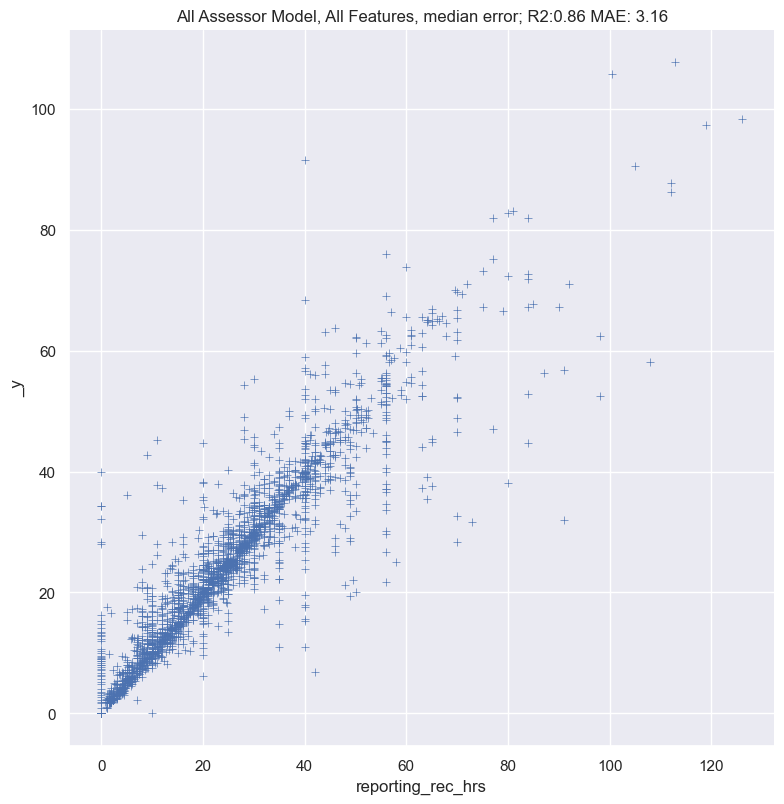

In [36]:
ax = sns.relplot(x=q_data.y_test, y=m_preds, marker='+', height=8)
ax.set(title=f'All Assessor Model, All Features, median error; R2:{mid_model.score(q_data.x_test, q_data.y_test):.02f} MAE: {np.mean(np.abs(q_data.y_test - m_preds)):.02f}')

In [37]:
vals = []
for i, p in enumerate(l_preds):
    vals.append([q_data.y_test.values[i], p, m_preds[i], h_preds[i]])
    
bounds_df = pd.DataFrame(vals, columns=['actual', 'low', 'med','high'])
bounds_df['range'] = bounds_df.high - bounds_df.low

# consider it in range if it is within 1 hr
bounds_df['in_range'] = np.where((bounds_df.actual - bounds_df.low > -1) &
                                 (bounds_df.actual - bounds_df.high < 1), 1, 0)
# exact in bounds
bounds_df['exact_in_range'] = np.where((bounds_df.actual >= bounds_df.low) & (bounds_df.actual <= bounds_df.high), 1, 0)

print(f'Percent in +/- 1 range: {bounds_df.in_range.sum() * 100 / bounds_df.shape[0]}')
print(f'Percent exact in range: {bounds_df.exact_in_range.sum() * 100 / bounds_df.shape[0]}')
bounds_df.head()

Percent in +/- 1 range: 94.52252252252252
Percent exact in range: 85.009009009009


,actual,low,med,high,range,in_range,exact_in_range
0,10.0,6.232359,9.363381,19.438769,13.206410,1,1
1,6.0,4.287772,5.346416,19.541478,15.253706,1,1
2,7.0,0.273512,7.608432,19.438769,19.165257,1,1
3,24.0,9.994927,22.865805,29.160301,19.165374,1,1
4,0.0,-0.048690,0.001718,19.438769,19.487459,1,1


In [38]:
bounds_tall_df = pd.melt(bounds_df, id_vars=['actual', 'in_range'], value_vars=['low', 'med', 'high'])
bounds_tall_df.head()

,actual,in_range,variable,value
0,10.0,1,low,6.232359
1,6.0,1,low,4.287772
2,7.0,1,low,0.273512
3,24.0,1,low,9.994927
4,0.0,1,low,-0.048690


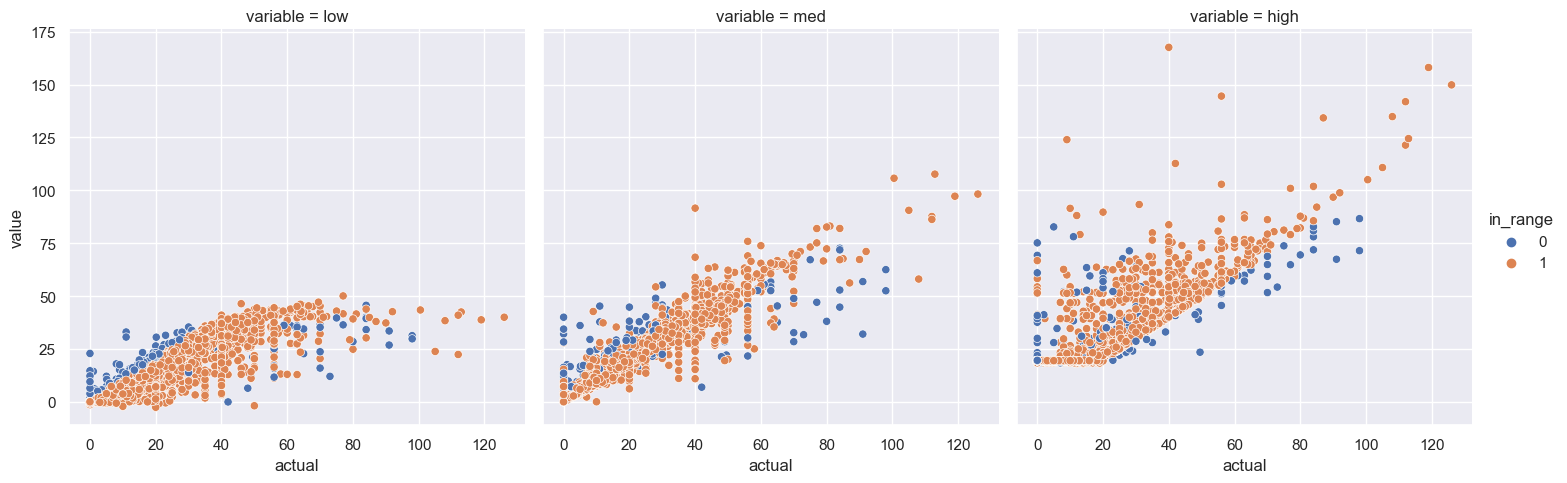

In [39]:
sns.relplot(data=bounds_tall_df, x='actual', y='value', col='variable', hue='in_range') 

In [40]:
bounds_df.range.describe()

count    2775.000000
mean       15.641646
std        12.881460
min        -0.479080
25%         6.890067
50%        12.957685
75%        19.271353
max       126.670566
Name: range, dtype: float64

In [41]:
bounds_df.loc[bounds_df.range <=0]

,actual,low,med,high,range,in_range,exact_in_range
1834,24.0,24.529356,24.092131,24.050277,-0.47908,1,0


### Patient Similarity model
- Find the k (in this case 10) most similar patients to a single patient within the context of the payer
- Can compare signle patient to mean/median min/max of 10 "neighbors"
- Can also look at the 10 neighbors, see how they are similar

In [24]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

#### These are the dimensions over which we calc similarity
Currently just adls and age

In [25]:
adls = [
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position'
]
similarity_features = adls + ['age']

In [26]:
pid = df.payer_id.unique()[0]
payers = df.payer_id.unique()
neighbors = {}
k = 10

for pid in payers:
    payer_df = df.loc[~df[target].isna()]
    payer_df = payer_df.loc[payer_df.payer_id == pid]
    x_train = payer_df[similarity_features]

    pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', preprocessing.StandardScaler())])
    pipe.fit(x_train)
    x = pipe.transform(x_train)
    nn = NearestNeighbors(n_neighbors=k).fit(x)
    distances, nn_idxs = nn.kneighbors()
    
    # get patient_ids
    for i, nn_idx in enumerate(nn_idxs): 
        neighbors[payer_df.iloc[i].patient_id] = payer_df.iloc[nn_idx].patient_id.values

In [27]:
rows = []
for pid in df.loc[~df[target].isna()].patient_id.unique():
    pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
    p = df.loc[df.patient_id == pid]
    
    rows.append([pid, p.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.median(), pid_neighbors.reporting_rec_hrs.min(), pid_neighbors.reporting_rec_hrs.max()])
nn_df = pd.DataFrame(rows, columns=['patient_id', 'rec_hrs', 'mean_nn', 'median_nn', 'min_nn', 'max_nn']) 
nn_df.head()

,patient_id,rec_hrs,mean_nn,median_nn,min_nn,max_nn
0,1816,6.0,11.300000,10.0,0.0,24.0
1,1817,12.0,17.136364,16.0,0.0,27.5
2,1818,0.0,11.100000,10.0,0.0,24.0
3,1832,18.0,9.100000,8.5,0.0,24.0
4,1834,12.0,21.000000,22.5,8.0,29.0


In [132]:
# calc ranges and mean abs error
nn_df = nn_df.assign(exact_in_range=np.where((nn_df.rec_hrs >= nn_df.min_nn) & (nn_df.rec_hrs <= nn_df.max_nn), 1, 0),
                     hrs_range=nn_df.max_nn - nn_df.min_nn,
                     in_range=np.where((nn_df.rec_hrs - nn_df.min_nn > -1) & (nn_df.rec_hrs - nn_df.max_nn < 1), 1, 0))

nn_df = nn_df.assign(mean_err=np.abs(nn_df.mean_nn - nn_df.rec_hrs), median_err=np.abs(nn_df.median_nn - nn_df.rec_hrs))

In [133]:
nn_df.head()

,patient_id,rec_hrs,mean_nn,median_nn,min_nn,max_nn,in_range,mean_err,median_err,exact_in_range,hrs_range
0,1816,6.0,11.300000,10.0,0.0,24.0,1,5.300000,4.0,1,24.0
1,1817,12.0,17.136364,16.0,0.0,27.5,1,5.136364,4.0,1,27.5
2,1818,0.0,11.100000,10.0,0.0,24.0,1,11.100000,10.0,1,24.0
3,1832,18.0,9.100000,8.5,0.0,24.0,1,8.900000,9.5,1,24.0
4,1834,12.0,21.000000,22.5,8.0,29.0,1,9.000000,10.5,1,21.0


In [129]:
print(f'Percent rec hrs in neighbors range: {nn_df.in_range.sum() * 100 / nn_df.shape[0]}')
print(f'Percent rec hrs in exact neighbors range: {nn_df.exact_in_range.sum() * 100 / nn_df.shape[0]}')

Percent rec hrs in neighbors range: 87.19668737060042
Percent rec hrs in exact neighbors range: 86.06211180124224


In [134]:
nn_df.describe()

,patient_id,rec_hrs,mean_nn,median_nn,min_nn,max_nn,in_range,mean_err,median_err,exact_in_range,hrs_range
count,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000,12075.000000
mean,15553.482070,22.560847,22.572043,21.632767,9.485419,39.440138,0.871967,7.808633,7.763304,0.860621,29.954718
std,11343.659632,16.938221,13.525467,13.532556,10.112642,22.144698,0.334141,8.141340,8.512671,0.346356,17.817019
min,1.000000,0.000000,1.450000,0.000000,0.000000,2.590000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,6371.500000,10.000000,12.330729,11.000000,0.000000,25.000000,1.000000,2.375000,2.000000,1.000000,17.045000
50%,11878.000000,21.000000,21.653846,21.000000,7.000000,36.000000,1.000000,5.342105,5.000000,1.000000,26.000000
75%,22588.500000,31.000000,30.602083,30.000000,16.000000,50.000000,1.000000,10.646429,10.500000,1.000000,40.000000
max,50521.000000,168.000000,110.727273,112.000000,56.000000,168.000000,1.000000,118.900000,126.500000,1.000000,154.000000


### Check random patient's neighbors
In practice could show top 10 most similar patients

In [175]:
pid = nn_df.patient_id.sample().values[0]
pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
print(f'Patient id {pid}, neighbor mean/range: {pid_neighbors.reporting_rec_hrs.mean()}; {pid_neighbors.reporting_rec_hrs.min()} - {pid_neighbors.reporting_rec_hrs.max()}')
pid_neighbors 

Patient id 11567, neighbor mean/range: 23.441176470588236; 8.0 - 36.0


,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,has_incontinence,incontinence_type,incontinence_frequency,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,alert_oriented_self,alert_oriented_place,alert_oriented_day_time,best_in_class_assessor,assessor,reporting_current_hrs,reporting_rec_hrs,submitted_at,submitted_last_30d,age,glaucoma_ddos,cataract_ddos,behavioral_health_ddos,osteoporosis_ddos,hiv_ddos,transplants_ddos,obesity_ddos,cancer_ddos,hip_pelvic_fracture_ddos,sclerosis_ddos,rheumatoid_arthritis_ddos,ckd_ddos,hyperlipidemia_ddos,diabetes_ddos,hypothyroidism_ddos,pressure_ulcer_ddos,weight_loss_ddos,heart_ddos,peptic_ulcer_ddos,anemia_ddos,substance_abuse_ddos,liver_ddos,disabled_ddos,fall_ddos,stroke_ddos,paralysis_ddos,hypertension_ddos,peripheral_vascular_ddos,coagulation_ddos,fluid_ddos,benign_prostatic_hyperplasia_ddos,tbi_ddos,neurocognitive_ddos,pulmonary_ddos,glaucoma_tc,cataract_tc,behavioral_health_tc,osteoporosis_tc,hiv_tc,transplants_tc,obesity_tc,cancer_tc,hip_pelvic_fracture_tc,sclerosis_tc,rheumatoid_arthritis_tc,ckd_tc,hyperlipidemia_tc,diabetes_tc,hypothyroidism_tc,pressure_ulcer_tc,weight_loss_tc,heart_tc,peptic_ulcer_tc,anemia_tc,substance_abuse_tc,liver_tc,disabled_tc,fall_tc,stroke_tc,paralysis_tc,hypertension_tc,peripheral_vascular_tc,coagulation_tc,fluid_tc,benign_prostatic_hyperplasia_tc,tbi_tc,neurocognitive_tc,pulmonary_tc
3799,6,8241,271030,24586,20,4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,True,bladder,occasional_incontinence,NaN,0.0,0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,0.0,0.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Anne Smith,31.50,31.50,2022-08-30 16:37:11.781538,False,73,0.0,3.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,3.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1227.75,6000.48,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,11263.99,337.66,90.35,9528.32,0.0,0.00,401.20,0.0,0.00,0.0,0.0,0.00,0.00,78.11,0.00,980.88,0.00,0.0,0.00,0.0,0.0,0.00,880.80
3837,6,8339,273414,9021,13,4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,True,NaN,occasional_incontinence,NaN,0.0,0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Erin Lenahan,35.25,35.25,2022-01-07 22:47:25.387901,False,72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,6.0,3.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,2873.31,0.00,646.77,404.86,0.00,0.0,0.00,1108.03,0.0,0.00,0.0,0.0,263.10,0.00,0.00,0.00,736.10,263.10,0.0,0.00,0.0,0.0,0.00,1496.48
4344,6,9443,272031,9137,10,4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,True,bladder,occasional_incontinence,NaN,0.0,0,1.0,1.0,0.0,0.0,2.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Sarah Saussy,46.00,20.00,2022-01-18 20:22:29.663709,False,71,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,7.0,172.0,1.0,19.0,0.0,0.0,0.0,5.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,273.65,0.0,0.0,0.0,0.00,756.85,0.0,0.0,768.59,107298.79,10881.73,14865.25,0.00,0.0,0.00,22559.96,0.0,1010.79,0.0,0.0,0.00,0.00,0.00,0.00,553.47,0.00,0.0,4.76,0.0,0.0,0.00,0.00
4446,6,9654,273724,7046,14,4,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,False,NaN,NaN,NaN,0.0,0,2.0,2.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,False,Maria Plunkett,31.00,31.00,2021-10-26 01:06:02.091778,False,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,1650.65,0.0,0.0,31.24,259.73,0.00,0.00,0.00,0.0,0.00,0.00,0.0,52.67,0.0,0.0,0.00,0.00,0.00,0.00,152.57,0.00,0.0

### Chronic conditions model
- Model based on chronic conditions found in claims data in the year leading up to the sfere submission
- Claims lag was used in feature generation
- This model could potentially be improved by including adls but keeping it just chronic conditions makes it easier to explain/interpret

In [33]:
base_cc_features = [
    'glaucoma',
    'cataract',
    'behavioral_health',
    'osteoporosis',
    'hiv',
    'transplants',
    'obesity',
    'cancer',
    'hip_pelvic_fracture',
    'sclerosis',
    'rheumatoid_arthritis',
    'ckd',
    'hyperlipidemia',
    'diabetes',
    'hypothyroidism',
    'pressure_ulcer',
    'weight_loss',
    'heart',
    'peptic_ulcer',
    'anemia',
    'substance_abuse',
    'liver',
    'disabled',
    'fall',
    'stroke',
    'paralysis',
    'hypertension',
    'peripheral_vascular',
    'coagulation',
    'fluid',
    'benign_prostatic_hyperplasia',
    'tbi',
    'neurocognitive',
    'pulmonary'
]
cc_ddos_features = [f'{f}_ddos' for f in base_cc_features]
cc_tc_features = [f'{f}_tc' for f in base_cc_features]
cc_features = ['payer_id', 'age'] + cc_tc_features
cc_features = ['payer_id', 'age'] + cc_ddos_features

In [34]:
cc_data = ds_matching.tt_split_by_sfere_ids(df, cc_features, target, test_sfere_ids=aa_data.test_df.sfere_id.values)

In [35]:
# payer_id is only categorical feature
cc_est = HistGradientBoostingRegressor(categorical_features=[0]).fit(cc_data.x_train, cc_data.y_train)
cc_preds = cc_est.predict(cc_data.x_test)

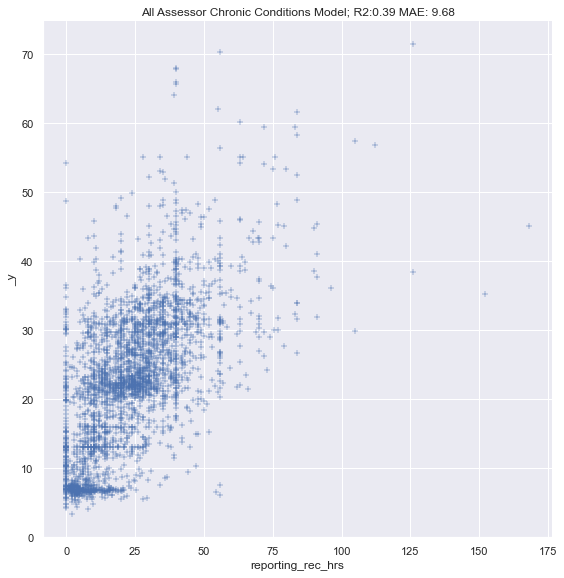

In [36]:
# preds vs rec
ax = sns.relplot(x=cc_data.y_test, y=cc_preds, marker='+', height=8)
ax.set(title=f'All Assessor Chronic Conditions Model; R2:{cc_est.score(cc_data.x_test, cc_data.y_test):.02f} MAE: {np.mean(np.abs(cc_data.y_test - cc_preds)):.02f}')

### Feature Importance
See what is driving each of the models

- Note: similarity model treats all features equally

In [37]:
from sklearn.inspection import permutation_importance

In [38]:
print('Best in class model features')
r = permutation_importance(bic_est, bic_data.x_test, bic_data.y_test,
                           n_jobs=-1,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{bic_data.features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Best in class model features
payer_id 0.441  +/- 0.010
dressing 0.045  +/- 0.004
toileting 0.037  +/- 0.003
transfer_chair_to_standing 0.023  +/- 0.002
meal_prep 0.022  +/- 0.003
grooming 0.018  +/- 0.002
bathing  0.015  +/- 0.002
transfer_bed_to_chair 0.014  +/- 0.002
transportation 0.010  +/- 0.001
age      0.010  +/- 0.003
housework 0.009  +/- 0.002
shopping 0.008  +/- 0.001
eating   0.008  +/- 0.001
medication_management 0.006  +/- 0.001
finances 0.005  +/- 0.002
calling_friends_and_family 0.004  +/- 0.001
comprehension 0.003  +/- 0.000
alert_oriented_self 0.003  +/- 0.001
alert_oriented_day_time 0.002  +/- 0.001
laundry  0.002  +/- 0.001


In [39]:
print('All assessor model features')
r = permutation_importance(aa_est, aa_data.x_test, aa_data.y_test,
                           n_jobs=-1,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{aa_data.features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

All assessor model features
payer_id 0.501  +/- 0.024
toileting 0.050  +/- 0.005
meal_prep 0.030  +/- 0.005
dressing 0.021  +/- 0.004
housework 0.016  +/- 0.003
grooming 0.015  +/- 0.003
transfer_bed_to_chair 0.014  +/- 0.003
eating   0.013  +/- 0.003
age      0.011  +/- 0.002
transportation 0.009  +/- 0.002
bathing  0.009  +/- 0.002
transfer_chair_to_standing 0.008  +/- 0.004
alert_oriented_day_time 0.007  +/- 0.002
medication_management 0.006  +/- 0.002
laundry  0.002  +/- 0.001
finances 0.002  +/- 0.001


In [40]:
print('All assesor, median quantile model with current hrs feature')
r = permutation_importance(mid_model, q_data.x_test, q_data.y_test,
                           n_jobs=-1,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{q_data.features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

All assesor, median quantile model with current hrs feature
reporting_current_hrs 1.383  +/- 0.037
payer_id 0.045  +/- 0.005
toileting 0.010  +/- 0.003
meal_prep 0.009  +/- 0.002
dressing 0.009  +/- 0.002
bathing  0.006  +/- 0.001
eating   0.003  +/- 0.001
housework 0.002  +/- 0.001
daily_routine_decisions 0.000  +/- 0.000
change_bed 0.000  +/- 0.000


In [41]:
print('Chronic conditions model')
r = permutation_importance(cc_est, cc_data.x_test, cc_data.y_test,
                           n_jobs=-1,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cc_data.features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Chronic conditions model
payer_id 0.604  +/- 0.020
paralysis_ddos 0.075  +/- 0.009
age      0.070  +/- 0.006
neurocognitive_ddos 0.047  +/- 0.008
pressure_ulcer_ddos 0.011  +/- 0.004
diabetes_ddos 0.006  +/- 0.003
behavioral_health_ddos 0.006  +/- 0.002
hypertension_ddos 0.005  +/- 0.002
sclerosis_ddos 0.005  +/- 0.002
cataract_ddos 0.005  +/- 0.002
rheumatoid_arthritis_ddos 0.004  +/- 0.002
benign_prostatic_hyperplasia_ddos 0.002  +/- 0.001
fall_ddos 0.002  +/- 0.001
substance_abuse_ddos 0.001  +/- 0.001


### Build outputs file
For each build predictions for test and training set

In [42]:
models = [
    ('best_in_class_assessor_model', bic_est, bic_data),
    ('all_assessor_model', aa_est, aa_data),
    ('lower_quantile_model', lower_model, q_data),
    ('mid_quantile_model', mid_model, q_data),
    ('upper_quantile_model', upper_model, q_data),
    ('chronic_condition_model', cc_est, cc_data)
]
# similarity model has slightly different api
# nn_df

In [84]:
# (name, model, data) = ('best_in_class_assessor_model', bic_est, bic_data)
result_dfs = []

for (name, model, data) in models:
    train_preds = model.predict(data.training_df[data.features])
    test_preds = model.predict(data.test_df[data.features])
    data.training_df = data.training_df.assign(**{name: train_preds})
    data.test_df = data.test_df.assign(**{name: test_preds})
    comb = pd.concat([data.training_df[['sfere_id', name]],  data.test_df[['sfere_id', name]]])
    comb.set_index('sfere_id', inplace=True)

    result_dfs.append(comb)

In [135]:
results_df = pd.concat(result_dfs, axis=1).reset_index()
# add patient ids and other info
results_df = results_df.merge(df[['sfere_id', 'patient_id', 'payer_id', 'reporting_rec_hrs', 'reporting_current_hrs']], on='sfere_id')
results_df = results_df.assign(is_test_set=np.where(results_df.sfere_id.isin(aa_data.test_df.sfere_id), 1, 0))

In [136]:
# add nearest neighbors
results_df = results_df.merge(nn_df[['patient_id', 'median_nn', 'min_nn', 'max_nn']], on='patient_id')

In [137]:
# add ensemble
non_cur_hrs_models = [
 'best_in_class_assessor_model',
 'all_assessor_model',
 'chronic_condition_model',
 'median_nn',
]
results_df = results_df.assign(ensemble=results_df[non_cur_hrs_models].mean(axis=1))
results_df = results_df.assign(
    ensemble_err=np.abs(results_df.ensemble - results_df.reporting_rec_hrs),
    best_in_class_err=np.abs(results_df.best_in_class_assessor_model - results_df.reporting_rec_hrs),
    all_assessor_err=np.abs(results_df.all_assessor_model - results_df.reporting_rec_hrs),
    mid_quantile_err=np.abs(results_df.mid_quantile_model - results_df.reporting_rec_hrs),
    chronic_condition_err=np.abs(results_df.chronic_condition_model - results_df.reporting_rec_hrs),
    median_nn_err=np.abs(results_df.median_nn - results_df.reporting_rec_hrs),
)

In [138]:
output_cols = [
 'patient_id',
 'payer_id',
 'sfere_id',
 'reporting_rec_hrs',
 'reporting_current_hrs',
 'is_test_set',
 'best_in_class_assessor_model',
 'all_assessor_model',
 'lower_quantile_model',
 'mid_quantile_model',
 'upper_quantile_model',
 'chronic_condition_model',
 'median_nn',
 'min_nn',
 'max_nn',
 'ensemble',
 'ensemble_err',
 'best_in_class_err',
 'all_assessor_err',
 'mid_quantile_err',
 'chronic_condition_err',
 'median_nn_err'
]
results_df[output_cols].head()

,patient_id,payer_id,sfere_id,reporting_rec_hrs,reporting_current_hrs,is_test_set,best_in_class_assessor_model,all_assessor_model,lower_quantile_model,mid_quantile_model,upper_quantile_model,chronic_condition_model,median_nn,min_nn,max_nn,ensemble,ensemble_err,best_in_class_err,all_assessor_err,mid_quantile_err,chronic_condition_err,median_nn_err
0,4,2,26241,35.0,35.0,0,36.027273,37.124210,24.058296,34.848624,35.103025,29.900917,33.0,24.0,50.0,34.013100,0.986900,1.027273,2.124210,0.151376,5.099083,2.0
1,4,2,6360,35.0,35.0,0,36.170008,36.680464,28.869123,33.989707,35.105834,30.646293,33.0,24.0,50.0,34.124191,0.875809,1.170008,1.680464,1.010293,4.353707,2.0
2,4,2,5642,40.0,49.0,0,30.530892,32.153234,31.707348,39.641472,48.952905,37.532355,33.0,24.0,50.0,33.304120,6.695880,9.469108,7.846766,0.358528,2.467645,7.0
3,102,2,27694,35.0,35.0,1,32.614709,32.563304,25.200506,32.278136,34.994340,18.490042,26.5,16.0,48.0,27.542014,7.457986,2.385291,2.436696,2.721864,16.509958,8.5
4,102,2,6256,26.0,40.0,0,34.561597,26.323738,26.886472,38.153386,40.009684,26.381952,26.5,16.0,48.0,28.441822,2.441822,8.561597,0.323738,12.153386,0.381952,0.5


In [139]:
results_df[output_cols].describe()

,patient_id,payer_id,sfere_id,reporting_rec_hrs,reporting_current_hrs,is_test_set,best_in_class_assessor_model,all_assessor_model,lower_quantile_model,mid_quantile_model,upper_quantile_model,chronic_condition_model,median_nn,min_nn,max_nn,ensemble,ensemble_err,best_in_class_err,all_assessor_err,mid_quantile_err,chronic_condition_err,median_nn_err
count,13874.000000,13874.000000,13874.000000,13874.000000,13512.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000,13874.000000
mean,14342.686824,5.594133,17799.957186,23.226010,28.165472,0.200014,23.573834,23.128438,16.265598,23.302059,32.359286,23.039321,22.164623,9.668120,40.246128,22.976554,6.958846,7.628962,6.602267,2.925820,8.927697,7.911167
std,11198.711629,2.722828,8423.142383,17.036424,21.087240,0.400025,14.696971,13.528884,11.781557,15.458514,16.445519,10.573142,13.417836,10.040109,21.920335,12.090580,7.136629,8.101831,6.882700,5.638406,8.551297,8.624565
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-3.705840,0.574709,-4.567051,0.002782,19.667419,2.948232,0.000000,0.000000,2.590000,1.744362,0.001908,0.000281,0.002080,0.000028,0.001847,0.000000
25%,5748.250000,4.000000,11228.250000,10.000000,13.000000,0.000000,12.581260,12.901002,6.015163,11.714393,20.407419,15.169717,12.000000,0.000000,26.000000,13.929740,2.218786,2.299311,2.004096,0.221338,3.139752,2.000000
50%,10809.500000,5.000000,16212.500000,21.500000,25.000000,0.000000,22.770151,22.767868,15.150895,22.186913,25.226691,22.840744,21.505000,8.000000,37.000000,22.953049,4.940587,5.106181,4.628747,0.996402,6.575203,5.070000
75%,21630.750000,8.000000,25528.750000,32.000000,38.000000,0.000000,31.702695,31.255236,25.087523,31.973453,40.001199,29.878861,30.500000,16.250000,52.000000,30.373299,9.403553,10.199471,8.869860,3.129268,12.155834,10.511250
max,50521.000000,13.000000,34712.000000,168.000000,168.000000,1.000000,117.727417,119.615804,45.559297,112.949349,157.206805,85.715569,112.000000,56.000000,168.000000,102.265484,115.060272,128.035212,102.399371,92.751827,122.855918,126.500000


In [140]:
results_df.loc[results_df.is_test_set == 1, output_cols].describe()

,patient_id,payer_id,sfere_id,reporting_rec_hrs,reporting_current_hrs,is_test_set,best_in_class_assessor_model,all_assessor_model,lower_quantile_model,mid_quantile_model,upper_quantile_model,chronic_condition_model,median_nn,min_nn,max_nn,ensemble,ensemble_err,best_in_class_err,all_assessor_err,mid_quantile_err,chronic_condition_err,median_nn_err
count,2775.000000,2775.000000,2775.000000,2775.000000,2713.000000,2775.0,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000,2775.000000
mean,14441.132973,5.678559,17937.297297,23.605045,28.412436,1.0,23.687073,23.155008,16.509106,23.487907,32.526490,22.836637,21.882786,9.747607,40.417715,22.890376,7.191805,7.406464,7.097320,3.185636,9.680931,8.046382
std,11154.521080,2.719477,8388.654896,17.357908,21.529057,0.0,14.878743,13.682188,11.965549,15.580348,16.565608,10.489770,13.327399,10.159999,22.874715,12.067803,7.447596,7.513601,7.625102,6.073506,9.525403,8.668479
min,7.000000,1.000000,2.000000,0.000000,0.000000,1.0,-3.705840,0.574709,-4.567051,0.002782,20.407419,3.368282,0.000000,0.000000,2.870000,1.865155,0.010684,0.001203,0.002080,0.000192,0.005851,0.000000
25%,5907.500000,4.000000,11468.000000,10.000000,13.000000,1.0,12.568826,12.768668,5.813637,11.553326,20.407419,14.953654,11.000000,0.000000,26.000000,13.630080,2.217186,2.348218,2.109190,0.303801,3.222619,2.125000
50%,10970.000000,5.000000,16291.000000,22.000000,25.000000,1.0,22.902058,22.787336,15.456252,22.667200,25.991399,22.779504,21.500000,8.000000,36.250000,22.974241,5.045446,5.090781,4.868377,1.201537,6.981657,5.375000
75%,21552.000000,8.000000,25794.500000,33.000000,39.000000,1.0,32.073151,31.530035,25.881633,32.475968,40.003152,29.746867,30.500000,17.000000,52.000000,30.557146,9.608250,9.731811,9.453037,3.474035,13.125986,11.000000
max,50508.000000,13.000000,34439.000000,168.000000,168.000000,1.0,105.193672,105.711803,44.663350,92.262325,156.057807,71.448679,112.000000,56.000000,168.000000,93.011365,94.508873,66.643679,102.399371,81.240855,122.855918,112.000000


In [141]:
results_df[output_cols].to_csv('/Users/bp/Downloads/ds_patient_matching_20221123.csv', index=False)

### Look at test set outlier detection

In [167]:
test_results = results_df.loc[results_df.is_test_set == 1, output_cols]
n_test = test_results.shape[0]
print(f'N test set: {n_test}')

N test set: 2775


In [178]:
# get chronic condition model std by payer
cc_err_std_by_payer = test_results.groupby('payer_id').chronic_condition_err.std().to_dict()
test_results = test_results.assign(cc_err_std_gt_2=test_results.apply(lambda x: x.chronic_condition_err > cc_err_std_by_payer[x.payer_id] * 1, axis=1))

In [180]:
# Flage some outliers
outliers = test_results.loc[
    (test_results.reporting_rec_hrs > test_results.upper_quantile_model) &
    (test_results.reporting_rec_hrs > test_results.max_nn) &
    (test_results.cc_err_std_gt_2)]

print(f'N outliers: {outliers.shape[0]}, {int(outliers.shape[0] * 10000 / n_test) / 100 }%')
outliers.head(20)

N outliers: 155, 5.58%


,patient_id,payer_id,sfere_id,reporting_rec_hrs,reporting_current_hrs,is_test_set,best_in_class_assessor_model,all_assessor_model,lower_quantile_model,mid_quantile_model,upper_quantile_model,chronic_condition_model,median_nn,min_nn,max_nn,ensemble,ensemble_err,best_in_class_err,all_assessor_err,mid_quantile_err,chronic_condition_err,median_nn_err,cc_err_std_gt_2
94,10478,2,27527,35.00,49.00,1,32.808545,22.044009,19.812726,38.727127,48.952347,24.458720,14.000,11.00,25.0,23.327818,11.672182,2.191455,12.955991,3.727127,10.541280,21.000,True
95,10573,2,24887,38.00,43.00,1,27.846116,22.254733,18.859476,34.825140,42.873118,25.540327,17.000,8.00,35.0,23.160294,14.839706,10.153884,15.745267,3.174860,12.459673,21.000,True
148,12000,4,25954,46.00,56.00,1,26.906671,18.111568,21.756020,45.520837,55.066202,33.706378,9.000,0.00,25.5,21.931154,24.068846,19.093329,27.888432,0.479163,12.293622,37.000,True
416,8288,6,15465,105.00,105.00,1,75.164472,49.070707,40.310283,87.095732,108.249190,29.821328,45.000,38.25,84.0,49.764127,55.235873,29.835528,55.929293,17.904268,75.178672,60.000,True
431,8499,6,12264,40.00,51.75,1,31.576118,27.678116,29.985125,45.593425,55.542619,20.451246,27.250,15.50,39.0,26.738870,13.261130,8.423882,12.321884,5.593425,19.548754,12.750,True
443,8655,6,7439,34.50,34.50,1,22.736454,20.863678,20.387846,29.306382,34.458189,22.361754,19.750,4.00,29.0,21.427972,13.072028,11.763546,13.636322,5.193618,12.138246,14.750,True
483,9085,6,23289,40.00,54.25,1,29.345922,23.352801,30.081380,42.279788,52.227972,22.466381,25.000,0.00,35.0,25.041276,14.958724,10.654078,16.647199,2.279788,17.533619,15.000,True
693,19988,9,25944,90.00,105.00,1,88.492206,58.062780,37.720895,68.395252,99.188653,44.852575,51.500,35.00,87.0,60.726890,29.273110,1.507794,31.937220,21.604748,45.147425,38.500,True
695,20026,9,25723,91.00,91.00,1,67.483295,44.916914,34.020648,45.566954,61.723899,31.829750,40.000,30.00,79.0,46.057490,44.942510,23.516705,46.083086,45.433046,59.170250,51.000,True
716,20314,9,25660,80.00,84.00,1,70.167538,43.692186,27.685902,34.351980,65.205324,42.143865,41.000,27.00,52.0,49.250897,30.749103,9.832462,36.307814,45.648020,37.856135,39.000,True


# Old
Can ignore below, saved for ease of pulling code snippets for future use

In [43]:
raise "Stop"

TypeError: exceptions must derive from BaseException

### Tuning

In [ ]:
parameters = {
    'max_iter': [1000],
    'max_depth': [3,5,20,25],
    'min_samples_leaf': [10, 20, 50, 75, 100],
    'l2_regularization': [0, .1, .5]
}
parameters

In [ ]:
est = HistGradientBoostingRegressor(categorical_features=[0])

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

clf = HalvingGridSearchCV(est, parameters, factor=2, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

clf.best_score_, clf.best_params_

### Compare to DL

In [ ]:
lm_preds = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_hrs_lm_sfere_preds_2.csv')
print(lm_preds.shape[0])
lm_preds.head()

In [ ]:
comb = tdf.merge(lm_preds, on='sfere_id')
print(comb.shape[0])
comb.head() 

In [ ]:
ax = sns.relplot(data=comb, x='reporting_rec_hrs', y='pred', marker='+', height=8)
ax.set(title=f'All Assessor Model, last 30d; R2:{est.score(X_test, y_test):.02f} MAE: {np.mean(np.abs(comb.reporting_rec_hrs - comb.pred)):.02f}')

In [ ]:
melted = pd.melt(comb, id_vars=['reporting_rec_hrs'], value_vars=['predicted_hours', 'pred'])
ax = sns.relplot(data=melted, x='reporting_rec_hrs', y='value', hue='variable', marker='+', height=8)

In [ ]:
comb = comb.assign(ensemble=comb.predicted_hours * .5 + comb.pred * .5)

In [ ]:
comb = comb.assign(rec_minus_ensemble=comb.reporting_rec_hrs - comb.ensemble)

In [ ]:
comb[['rec_minus_ensemble', 'rec_minus_pred']].abs().mean()

### Check out embeddings

In [ ]:
emb = pd.read_csv('data/ds_hrs_lm_sfere_encodings_20221116.csv')

In [ ]:
emb.head()

In [ ]:
comb = comb.merge(emb, on='sfere_id')
comb.head()

In [ ]:
comb.encoding.dtype
a = [1,2,3]
b = np.array(a)
b

In [ ]:
# need to transform list str into actual list
import ast
comb.encoding = comb.encoding.apply(ast.literal_eval)
comb.encoding = comb.encoding.apply(np.array)

In [ ]:
vectors = np.zeros((comb.shape[0], 400))
for i, r in enumerate(comb.encoding):
    vectors[i] = r

In [ ]:
from scipy.spatial import distance

In [ ]:
target = comb.encoding.values[1]
# distances = distance.cdist([target], vectors, "cosine")[0]
distances = distance.cdist([target], vectors, "euclidean")[0]
min_index = np.argmin(distances)
min_distance = distances[min_index]
# print("Most similar vector to target is index %s with %s" % (max_index, max_similarity))

In [ ]:
sim_idx = [si for si in np.argsort(distances)[0:11]]
comb.loc[sim_idx]

### Reduce dimensions of emb to feed to boosted tree model

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vectors)

In [ ]:
xy = pca.transform(vectors)
xy

In [ ]:
sns.relplot(x=xy[:, 0], y=xy[:,1])

### Look at similarity based just on adl distances